In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import time

In [2]:
# cosntants
DATA = "../data/7_Preprocess_Final.csv"
MIN_PTS = 3
EPS = 1.5
TMP_DATA = np.random.randint(0, 15, (10, 2))
DISTANCE_METRIC = "Euclidean"

In [3]:

# Preprocess the data
def process_data(data):
    print("Processing data(one hot encoding)")
    df = pd.read_csv(data).values[:, :5]
    n_columns = df.shape[1]
    dtypeO = []
    for i in range(n_columns):
        if df[:, i].dtype == 'O':
            dtypeO.append(i)
            (_, index) = np.unique(df[:, i], return_index=True)
            unique_labels = []
            for j in index:
                unique_labels.append(df[j, i])
            dft = []
            for j in unique_labels:
                tmp = (df[:, i] == j).astype(int)
                dft.append(tmp)
            dft = np.array(dft)
            dft = pd.DataFrame(dft.T, columns=unique_labels)
            df = pd.concat([pd.DataFrame(df), dft], axis=1)
            df = df.values
    df = np.delete(df, np.array(dtypeO), axis = 1)
    print(df)
    return df

class DBSCAN():
    def __init__(self, data, minpts, eps):
        self.data = data
        self.minpts = minpts
        self.eps = eps
        self.cls = ['UNCLASSIFIED'] * (self.data.shape[0])
        self.core, self.neighbors = self.core_neighbors()
        self.n_clusters = 0
        self.noise = []
    
    # get the core points and the nighbors of all the points
    # core points = points whih hve >minpts in their eps neighborhood
    def core_neighbors(self):
        num_examples = self.data.shape[0]
        neighbors = []
        core = []
        for i in range(num_examples):
            d = []
            for j in range(num_examples):
                d.append(math.sqrt(np.sum((self.data[i]-self.data[j])**2)))
            d = np.array(d)
            d = d <= self.eps
            n = []
            for j, val in enumerate(d):
                if val == True and j!=i:
                    n.append(j)
            
            neighbors.append(n)
            if(len(n) >= self.minpts):
                core.append(i)
                self.cls[i] = 'CLASSIFIED'
        
        return core, neighbors
    
    # get clusters formed just by core points
    def get_basic_clusters(self, clusters):
        for i in self.core:
            if clusters[i] == -1:
                clusters[i] = self.n_clusters + 1
                self.n_clusters += 1
            if self.cls[i] == 'UNCLASSIFIED' or self.cls[i] == 'NOISE':
                self.cls[i] == 'CLASSIFIED'
            tmp = self.neighbors[i]
            for j in tmp:
                self.cls[j] = 'CLASSIFIED'
                clusters[j] = clusters[i]
        
    
    # complete the clusters by including rest of the points
    # that is recursive checks, if one point is classified
    # then all it's neighbors are included and then their
    # neighbors and so on.
    def complete(self, clusters):        
        classified = []
        for i, val in enumerate(self.cls):
            if val == 'CLASSIFIED':
                classified.append(i)
        
        for i in classified:
            tmp = self.neighbors[i]
            for j in tmp:
                self.cls[j] = 'CLASSIFIED'
                clusters[j] = clusters[i]
        
        for i, val in enumerate(self.cls):
            if val != 'CLASSIFIED':
                self.noise.append(self.data[i])
        
        
    def __call__(self):
        if self.n_clusters !=0:
            self.__init__(self.data, self.minpts, self.eps)
        clusters = {i:-1 for i in range(len(self.neighbors))}
        self.get_basic_clusters(clusters)
        self.complete(clusters)
        cluster_list = []
        
        for i in range(1, self.n_clusters+1):
            tmp = []
            for j in clusters.keys():
                if clusters[j] == i:
                    tmp.append(self.data[int(j)])
            cluster_list.append(tmp)
        
        return np.array(cluster_list), np.array(self.noise)

In [4]:
clustersd = dict()
array = np.array(
    [[3, 3],
    [3, 4],
    [3, 5],
    [3, 6],
    [4, 6],
    [5, 6],
    [4, 10],
    [6, 6],
    [7, 6],
    [7, 5],
    [7, 4],
    [7, 3],
    [5, 2],
    [5, 1],
    [5, 0],
    [6, 0], 
    [10, 20],
    [1, 1]
    ]
)

model = DBSCAN(array, minpts=2, eps=2)
clusters, noise = model()


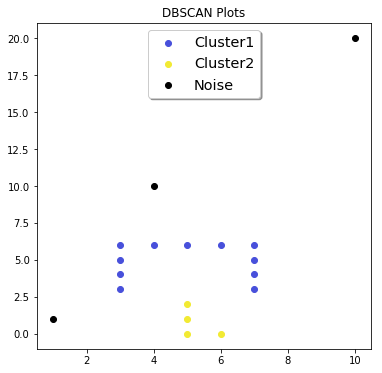

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
colormap = np.array([0, 0, 0])
for k, val in enumerate([clusters, noise]):
    if k == 0:
        for index, i in enumerate(val):
            x = [j[0] for j in i]
            y = [j[1] for j in i]
            ax.scatter(x, y, c=np.random.rand(3,), label="Cluster"+str(index+1))
    else:
        ax.scatter(val[:, 0], val[:, 1], c='black', label="Noise")
plt.title("DBSCAN Plots")
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.savefig("../plots/DBSCAN/plo1.png")

# ON ACTUAL DATA

## WARNING ON A 6 CORE I7-8750H, with 4.10GHz boost clock
## It took more than 2 days to just get the basic clusters
## after that laptop is shut down due to overheating
## run at your own risk

In [6]:
# data = process_data(DATA)
# model = dbscan(DATA, minpts=1000, eps=3)
# clusters, noise = model()